# <center>FONCTION CARTOGRAPHIE</center> #

## <font color='#5BA69E'>INTRODUCTION</font> ##

Ce notebook a pour objectif de réaliser de multiples cartographies pour une variable de l'INSEE à définir par l'utilisateur.  
Le cadre est limité à la France métropolitaine et les DOM TOM sont donc exclus.

L'utilisateur doit disposer d'un fichier csv avec la ou les variables qu'il souhaite cartographier.  
Le fichier doit obligatoirement contenir la variable CODGEO au format 'string'.

## <font color='#5BA69E'>INSTRUCTIONS</font> ##

Commencez par déposer votre fichier csv dans le répertoire **files** (qui contient ce même notebook) puis renseignez le nom de fichier dans la variable ci-dessous. 

In [1]:
nom_dataset = 'variables_ets.csv'

Définissez la variable cible de votre dataset à cartographier (ex: salaire médian, nombre d'établissements.)

In [2]:
nom_variable = 'ets_total'

Définissez une aire d'attraction de ville comme focus.

In [3]:
aire_attraction = 'Rouen'

Définir le titre des graphiques en fonction de la variable sélectionnée (et indépendament des zones géographiques qui s'afficheront pour chaque graphique dans le titre)

In [4]:
titre = "Nombre d'établissements"

Pour les cartographies par région, département et aires d'attraction des villes, il est nécessaire de définir de quelle manière on souhaite aggréger les données (exemple si l'on souhaite connaître le nombre d'établissement par zone géographique, on choisira 'sum' pour avoir la somme des établissements par région, département, ville).  

A préciser dans la variable ci-dessous :

In [5]:
aggfunc = 'sum'

## <font color='#5BA69E'>IMPORT LIBRAIRIES</font> ##

In [6]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns

#élargissement de la visualisation des tableaux pandas
pd.set_option('display.max_columns', None)

#suppression des warnings
import warnings
warnings.filterwarnings('ignore')

## <font color='#5BA69E'>CHARTE GRAPHIQUE</font> ##

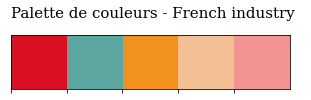

In [7]:
sns.palplot(["#D91122", "#5BA69E", "#F2911B", "#F2C094", "#F29494"])
plt.title("Palette de couleurs - French industry  ",loc='left',fontfamily='serif',fontsize=15,y=1.2)
plt.show()

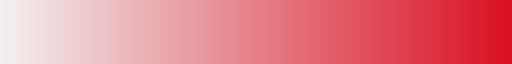

In [8]:
pal = sns.light_palette("#D91122", input='rgb', as_cmap=True, n_colors=10)
pal


## FONCTION ##

In [11]:
def carto_french_indus(nom_dataset, nom_variable, aire_attraction, titre, aggfunc):
    #import fichier shapefile pour réaliser les fonds de cartes
    gdf = geopandas.read_file('../files/fond_AAV2020_geo20_metro/zMetro.shp')
    
    #import du csv donnée en argument de la fonction
    data = pd.read_csv('../files/'+nom_dataset, dtype={'CODGEO': 'string'})
    
    #import du nom des régions et création d'un dictionnaire pour des besoins de mapping
    regions = pd.read_csv('../files/region2020.csv', dtype={'reg': 'string'})
    regions_dict = dict(list(zip(regions.reg, regions.libelle)))
    
    #import du nom des départements et création d'un dictionnaire pour des besoins de mapping
    dep = pd.read_csv('../files/departement2020.csv')
    dep_dict = dict(list(zip(dep.dep, dep.dep)))
    
    #import des aires d'attraction des villes et création d'un dictionnaire pour des besoins de mapping
    aav = pd.read_csv('../files/AAV20.csv', sep=';')
    aav_dict = dict(list(zip(aav.AAV2020, aav.LIBAAV2020)))
    
    
    invalid_codgeo_list = []
    invalid_codgeo = 0
    for codgeo in data.CODGEO:
        if len(codgeo) != 5:
            invalid_codgeo += 1
            invalid_codgeo_list.append(codgeo)
    print('Nombre de CODGEO invalides (pas au format string ou pas 5 caractères) :', invalid_codgeo)
    print('Liste des CODGEO posant problème :', invalid_codgeo_list)
    
    data = data[['CODGEO', nom_variable]]
    gdf_data = gdf.merge(data, how='left', on='CODGEO')
    print('Après le merge avec le fond de carte,', nom_variable, 'contient', gdf_data[nom_variable].isna().sum(), 'manquants')
    print('Extrait des manquants identifiés :')
    display(gdf_data[gdf_data[nom_variable].isna()].head())

    #aggregation de la colonne geometry par REG
    gdf_data_reg = gdf_data.dissolve(by='REG', aggfunc=aggfunc)
    gdf_data_reg['REG_label'] = gdf_data_reg.index.map(regions_dict)
    
    #aggregation de la colonne geometry par DEP
    gdf_data_dep = gdf_data.dissolve(by='DEP', aggfunc=aggfunc)
    gdf_data_dep['DEP_label'] = gdf_data_dep.index.map(dep_dict) 
    
    #aggregation de la colonne geometry par aires d'attraction des villes
    gdf_data_aav = gdf_data[gdf_data.LIBAAV2 == aire_attraction].reset_index(drop=True)
    gdf_data_ville = gdf_data_aav[gdf_data_aav.LIBGEO == aire_attraction].reset_index(drop=True)
    gdf_data_suburbs = gdf_data_aav[gdf_data_aav.LIBGEO != aire_attraction].reset_index(drop=True)
    
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX  REGIONS  XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    

    fig, ax = plt.subplots(figsize=(30,30))
    
    #Ajout d'une variable coords pour mapper les labels sur les zone géographiques
    gdf_data_reg['coords'] = gdf_data_reg['geometry'].apply(lambda x: x.representative_point().coords[:])
    gdf_data_reg['coords'] = [coords[0] for coords in gdf_data_reg['coords']]
    
    #Création de la cartographie
    gdf_data_reg.plot( ax=ax,
                     column=nom_variable,
                     edgecolor='#565656',
                     cmap=pal,
                     legend=True,
                     legend_kwds={'shrink': 0.7}
                    )
    #Ajout des labels sur les zones géographiques
    for idx, row in gdf_data_reg.iterrows():
        plt.annotate(s=row['REG_label'], xy=row['coords'],
                     horizontalalignment='center', fontname='sans-serif', fontsize=14 )

    #Optimisation de la cartographie
    plt.title(titre + ' ' + 'par région \n', fontsize=48, fontname='sans-serif')
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    jauge = fig.axes[1]
    jauge.tick_params(labelsize=20)
    plt.show()
    
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX  DEPARTEMENTS  XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX  
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    
    fig, ax = plt.subplots(figsize=(30,30))
    
    #Ajout d'une variable coords pour mapper les labels sur les zone géographiques
    gdf_data_dep['coords'] = gdf_data_dep['geometry'].apply(lambda x: x.representative_point().coords[:])
    gdf_data_dep['coords'] = [coords[0] for coords in gdf_data_dep['coords']]
    
    #Création de la cartographie
    gdf_data_dep.plot( ax=ax,
                     column=nom_variable,
                     edgecolor='#565656',
                     cmap=pal,
                     legend=True,
                     legend_kwds={'shrink': 0.7}
                    )
    #Ajout des labels sur les zones géographiques
    for idx, row in gdf_data_dep.iterrows():
        if row['DEP_label'] in ['75', '92', '93', '94']:
            continue
        else:
            plt.annotate(s=row['DEP_label'], 
                         xy=row['coords'], 
                         horizontalalignment='center', 
                         fontname='sans-serif', 
                         fontsize=12 )

    #Optimisation de la cartographie
    plt.title(titre + ' ' + 'par département \n', fontsize=48, fontname='sans-serif')
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    jauge = fig.axes[1]
    jauge.tick_params(labelsize=20)
    plt.show()    

    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX  AIRE D'ATTRACTION DES VILLES  XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX  
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    
    fig, ax = plt.subplots(figsize=(30,30))
    
    #Ajout d'une variable coords pour mapper les labels sur les zone géographiques
    gdf_data_suburbs['coords'] = gdf_data_suburbs['geometry'].apply(lambda x: x.representative_point().coords[:])
    gdf_data_suburbs['coords'] = [coords[0] for coords in gdf_data_suburbs['coords']]
    
    #Création de la cartographie
    gdf_data_suburbs.plot( ax=ax,
                     column=nom_variable,
                     edgecolor='#565656',
                     cmap=pal,
                     legend=True,
                     legend_kwds={'shrink': 0.7}
                    )
    
    """
    #Ajout des labels sur les zones géographiques
    for idx, row in gdf_data_suburbs.iterrows():
        plt.annotate(s=row['LIBGEO'], 
                        xy=row['coords'], 
                        horizontalalignment='center', 
                        fontname='sans-serif', 
                        fontsize=9 )
    """
    
    #Ajout d'une variable coords pour mapper les labels sur les zone géographiques
    gdf_data_ville['coords'] = gdf_data_ville['geometry'].apply(lambda x: x.representative_point().coords[:])
    gdf_data_ville['coords'] = [coords[0] for coords in gdf_data_ville['coords']]
        
    gdf_data_ville.plot( 
                ax=ax,
                color='#5BA69E',
                alpha=0.9
               )
    #Ajout des labels sur les zones géographiques
    for idx, row in gdf_data_ville.iterrows():
        plt.annotate(s=row['LIBGEO'], 
                        xy=row['coords'], 
                        horizontalalignment='center', 
                        fontname='sans-serif', 
                        fontsize=18 )

    #Optimisation de la cartographie
    plt.title(titre + ' - ' + aire_attraction, fontsize=48, fontname='sans-serif')
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    jauge = fig.axes[1]
    jauge.tick_params(labelsize=20)
    plt.show()       
    

Nombre de CODGEO invalides (pas au format string ou pas 5 caractères) : 0
Liste des CODGEO posant problème : []
Après le merge avec le fond de carte, ets_total contient 122 manquants
Extrait des manquants identifiés :


,REG,DEP,CODGEO,LIBGEO,AAV20,LIBAAV2,CATEAAV,LIBCATE,TAAV20,LIBTAAV,geometry,ets_total
100,84,01,01111,Conand,243,Ambérieu-en-Bugey,20,Commune de la couronne,1,Aire de moins de 50 000 habitants,"POLYGON ((894682.974 6530591.055, 892203.958 6...",NaN
610,32,02,02225,Courchamps,001,Paris,20,Commune de la couronne,5,Aire de Paris,"POLYGON ((720092.981 6890490.981, 719394.968 6...",NaN
1058,32,02,02695,Saint-Thibaut,036,Reims,20,Commune de la couronne,3,Aire de 200 000 à moins de 700 000 habitants,"POLYGON ((744333.996 6908576.037, 743731.971 6...",NaN
1176,32,02,02817,Ville-Savoye,036,Reims,20,Commune de la couronne,3,Aire de 200 000 à moins de 700 000 habitants,"POLYGON ((747726.944 6910361.011, 747115.048 6...",NaN
1582,93,04,04093,Gigors,119,Gap,20,Commune de la couronne,2,Aire de 50 000 à moins de 200 000 habitants,"POLYGON ((948680.018 6372366.952, 947664.993 6...",NaN


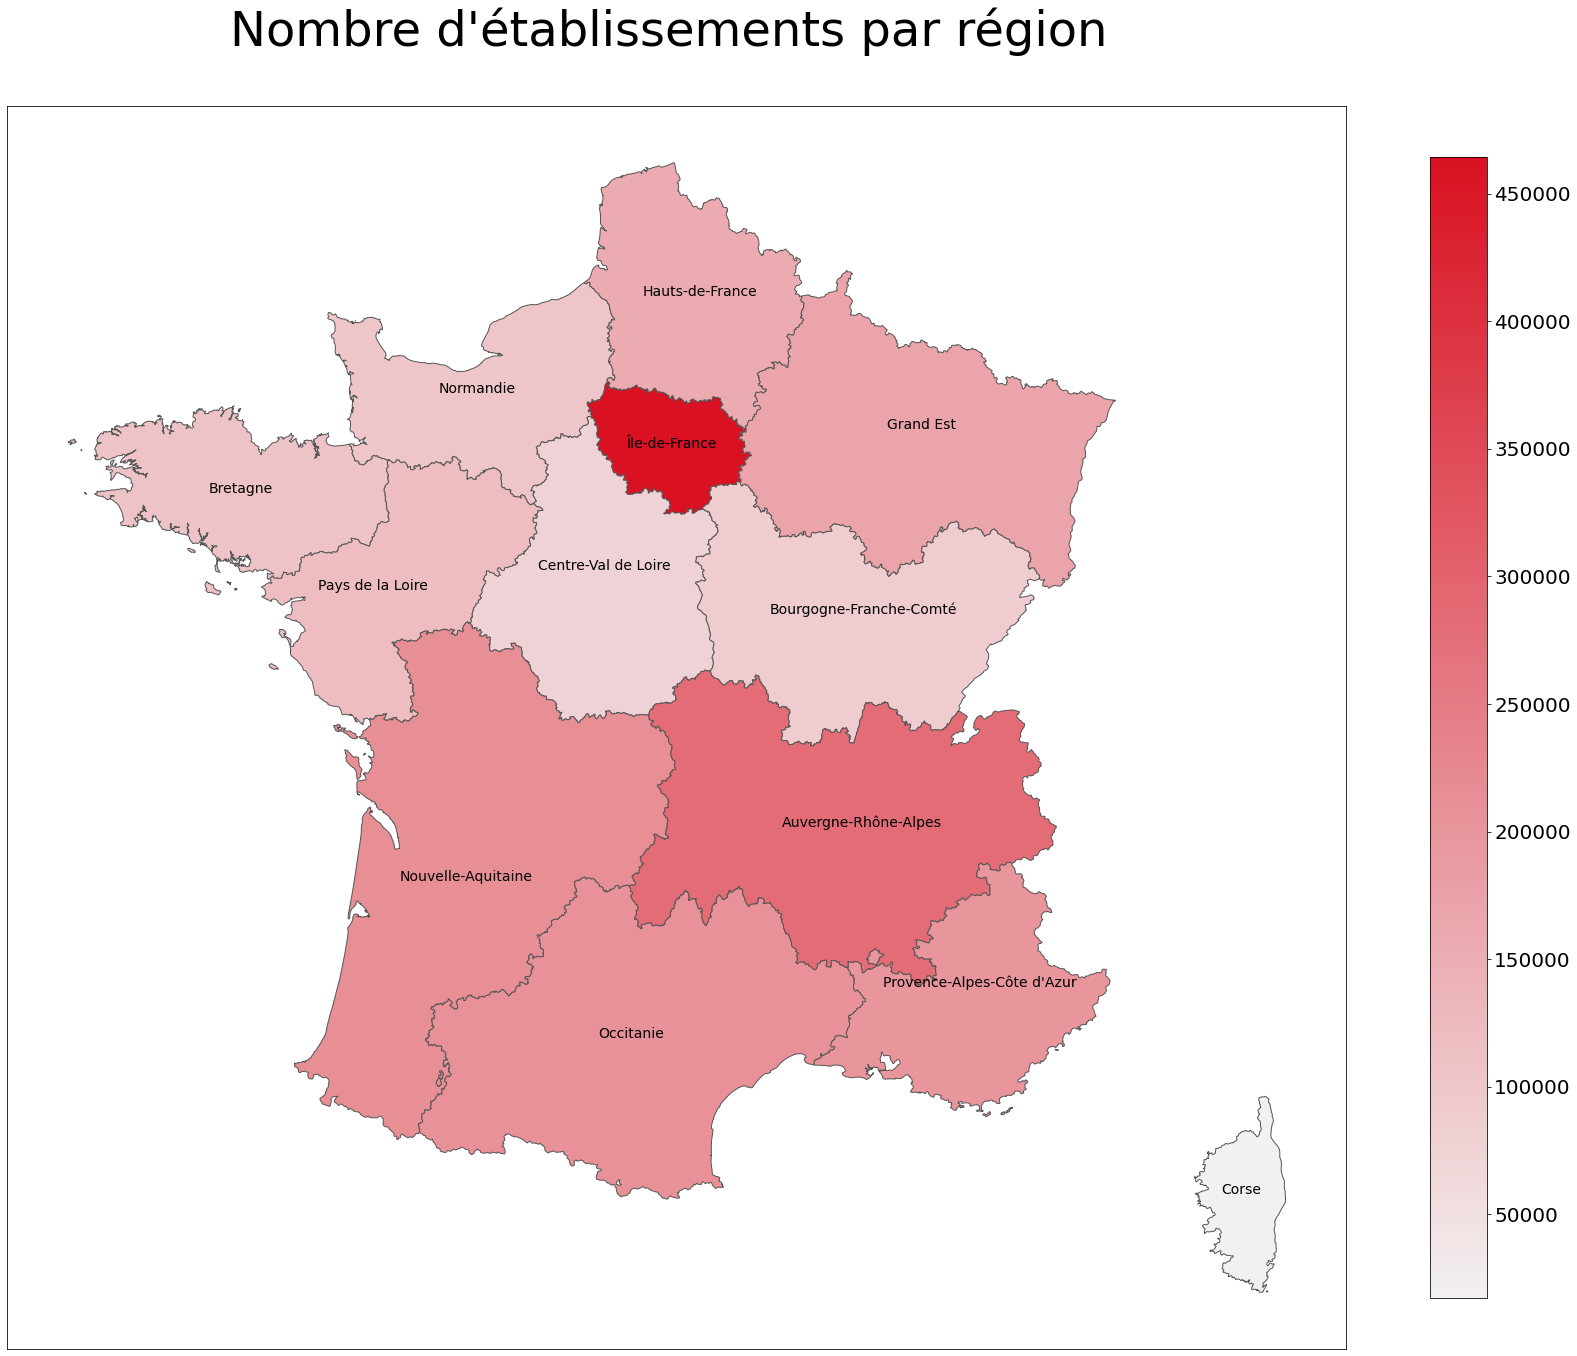

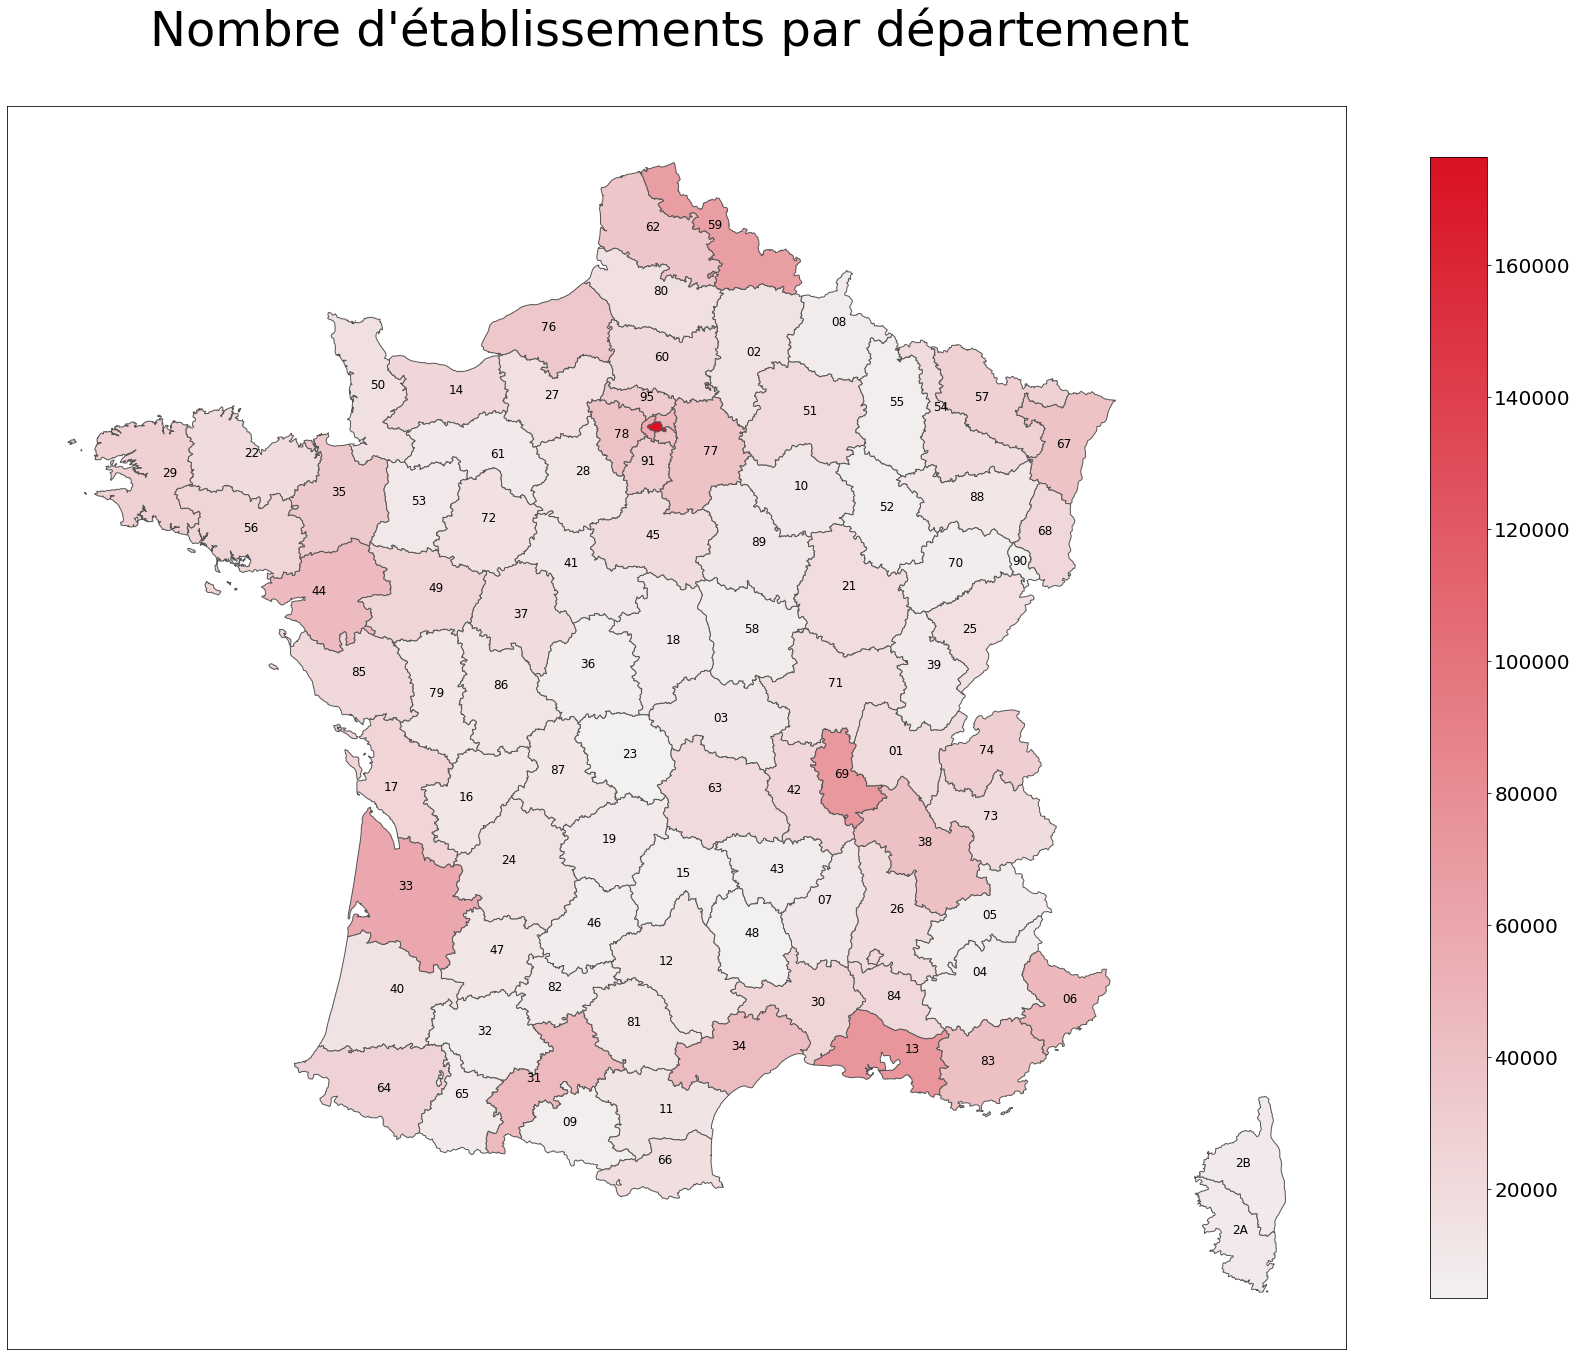

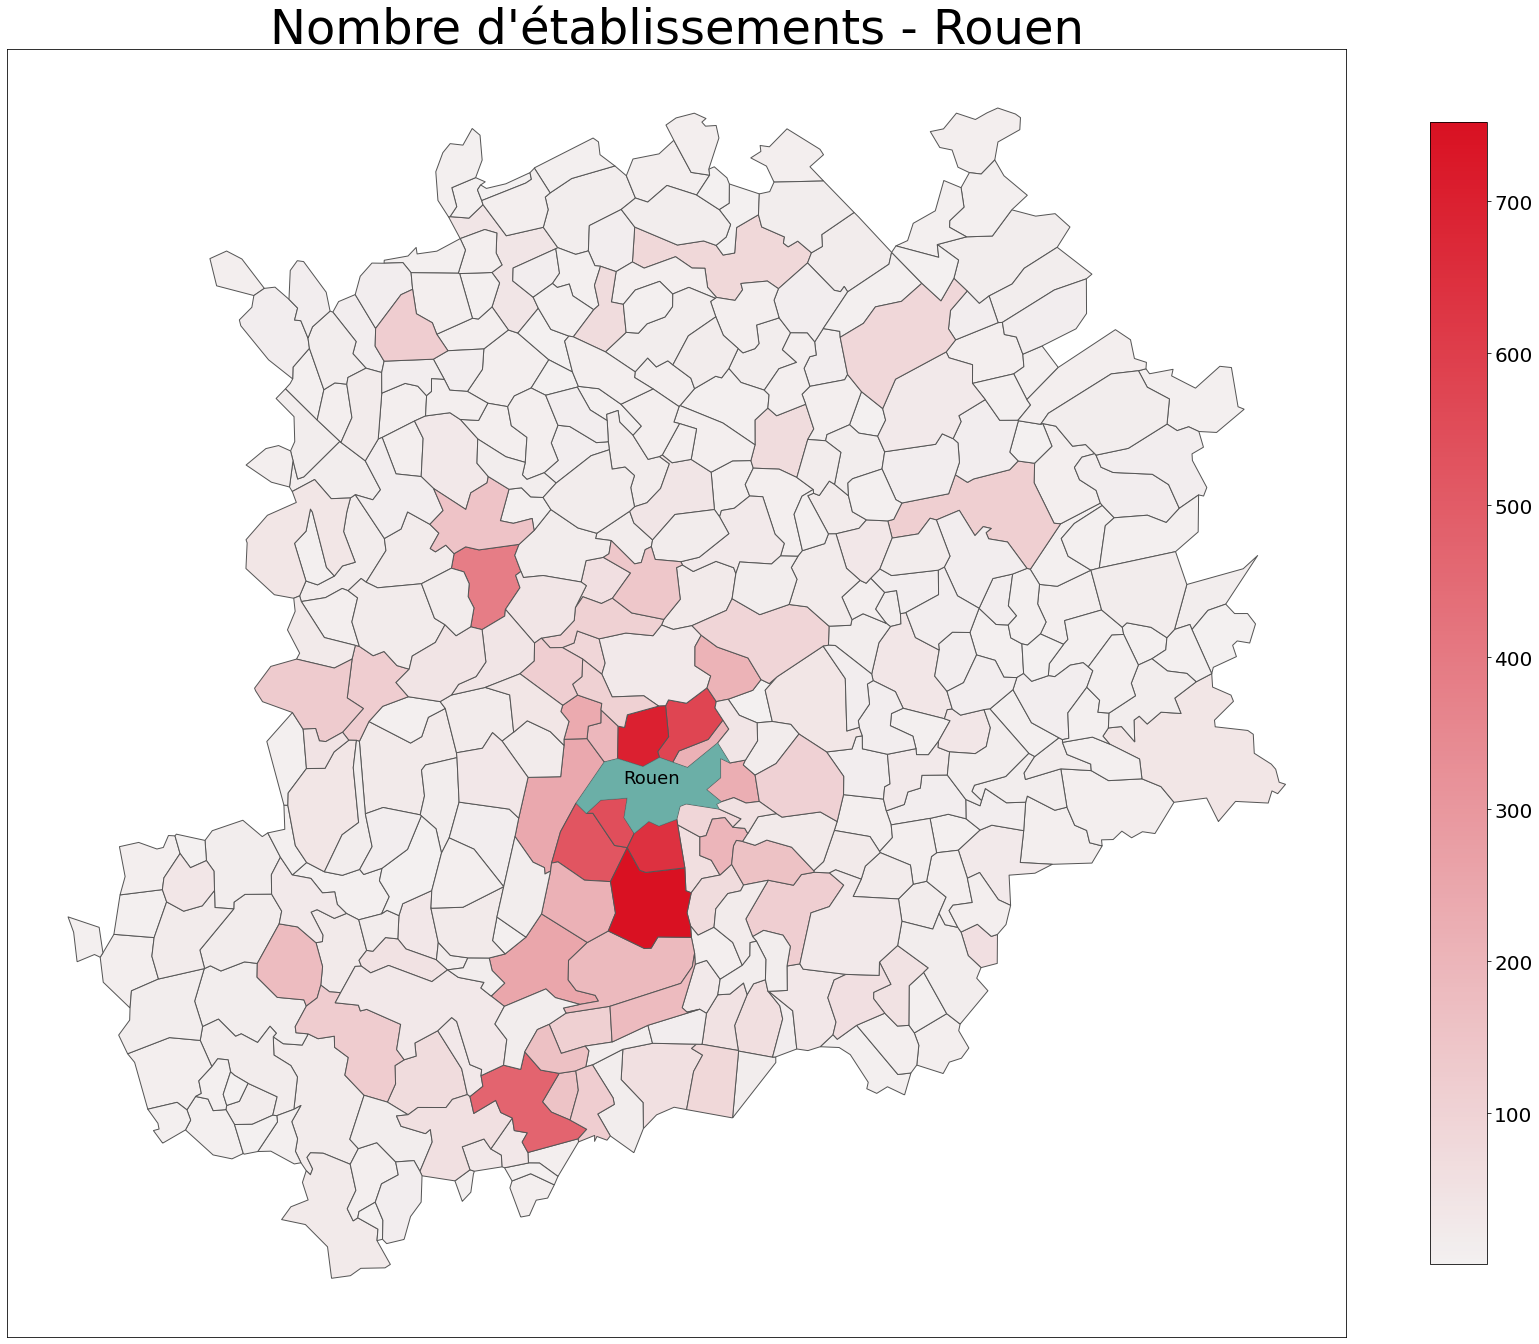

In [12]:
carto_french_indus(nom_dataset, nom_variable, aire_attraction, titre, aggfunc)